In [52]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
import librosa
%matplotlib inline

In [53]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1


In [54]:
#read the csv file
df = pd.read_csv('/home/darpan/Documents/audio classification/instruments.csv')
df.head()

,fname,label
0,5388d14d.wav,Saxophone
1,c685f05f.wav,Saxophone
2,36d20ab5.wav,Saxophone
3,d6665734.wav,Saxophone
4,7352e28f.wav,Saxophone


In [55]:
df.set_index('fname', inplace = True)

In [56]:
for f in df.index:
    rate, signal = wavfile.read('/home/darpan/Documents/audio classification/wavfiles/'+f)
    df.at[f,'length']=signal.shape[0]/rate
    

In [57]:
classes = list(np.unique(df.label))
classes

['Acoustic_guitar',
 'Bass_drum',
 'Cello',
 'Clarinet',
 'Double_bass',
 'Flute',
 'Hi-hat',
 'Saxophone',
 'Snare_drum',
 'Violin_or_fiddle']

In [58]:
class_dist = df.groupby(['label'])["length"].mean()
class_dist

label
Acoustic_guitar     6.948667
Bass_drum           1.937333
Cello               5.000667
Clarinet            6.596000
Double_bass         3.206000
Flute               8.054667
Hi-hat              3.357333
Saxophone           7.124000
Snare_drum          3.987333
Violin_or_fiddle    4.530000
Name: length, dtype: float64

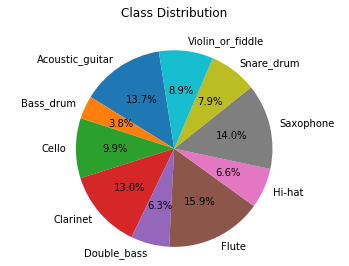

In [59]:
fig,ax = plt.subplots()
ax.set_title("Class Distribution", y = 1.08)
ax.pie(class_dist, labels = class_dist.index,shadow=False,autopct='%1.1f%%',startangle=99)
ax.axis('equal')
plt.show()

In [60]:
df.reset_index(inplace = True)

In [67]:
def cal_fft(y,rate):
    n = len(y)
    freq = np.fft.rfftfreq(n,d = 1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return(Y,freq)

In [69]:
signals = {}
fft = {}
fbank = {}
mfccs = {}

for c in classes:
    wav_file = df[df.label == c].iloc[0,0]
    signal, rate = librosa.load("/home/darpan/Documents/audio classification/wavfiles/"+wav_file, sr = 44100)
    signals[c]=signal
    fft[c] = cal_fft(signal,rate)
    
    bank= logfbank(signal[:rate],rate,nfilt = 26,nfft = 1103).T
    fbank[c]=bank
    mel = mfcc(signal[:rate],rate,numcep = 13,nfilt = 26,nfft = 1103).T
    mfccs[c] =mel
    

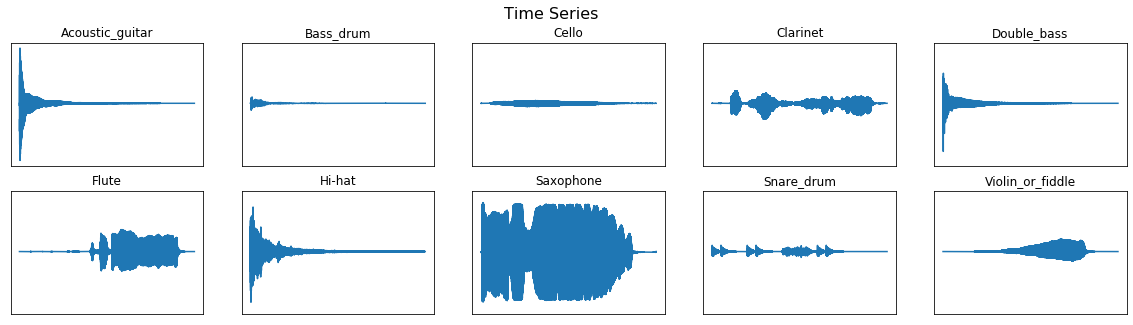

In [70]:
plot_signals(signals)
plt.show()

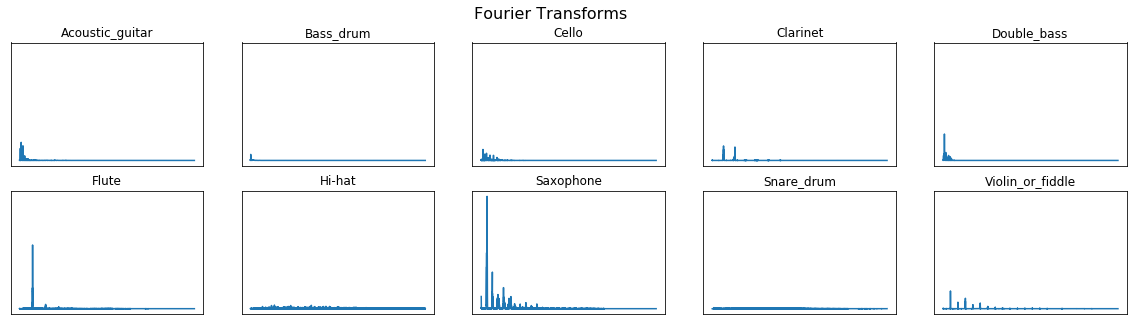

In [72]:
plot_fft(fft)
plt.show()

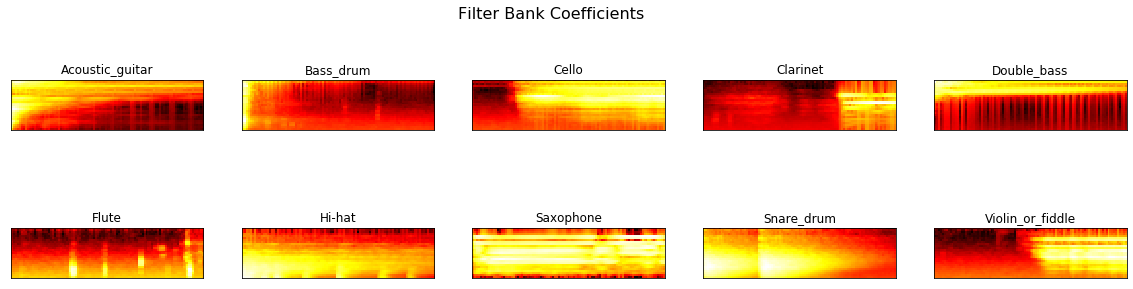

In [74]:
plot_fbank(fbank)
plt.show()

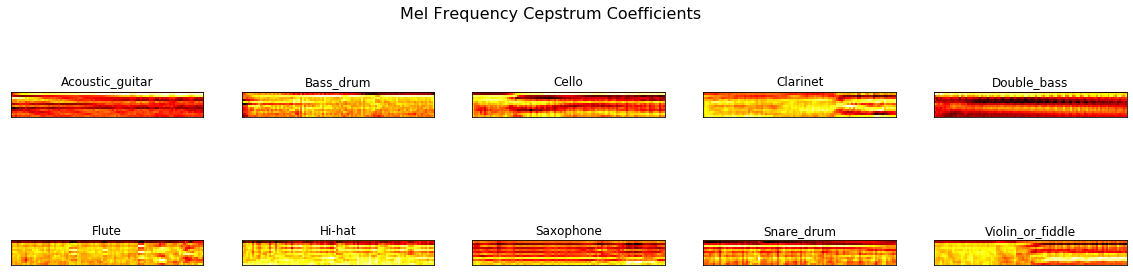

In [77]:
plot_mfccs(mfccs)
plt.show()

In [78]:
def envelope(y,rate,threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window = int(rate/10), min_periods = 1, center = True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask
            

In [79]:
signals = {}
fft = {}
fbank = {}
mfccs = {}

for c in classes:
    wav_file = df[df.label == c].iloc[0,0]
    signal, rate = librosa.load("/home/darpan/Documents/audio classification/wavfiles/"+wav_file, sr = 44100)
    mask = envelope(signal, rate, 0.0005)
    signal = signal[mask]
    signals[c]=signal
    fft[c] = cal_fft(signal,rate)
    
    bank= logfbank(signal[:rate],rate,nfilt = 26,nfft = 1103).T
    fbank[c]=bank
    mel = mfcc(signal[:rate],rate,numcep = 13,nfilt = 26,nfft = 1103).T
    mfccs[c] =mel

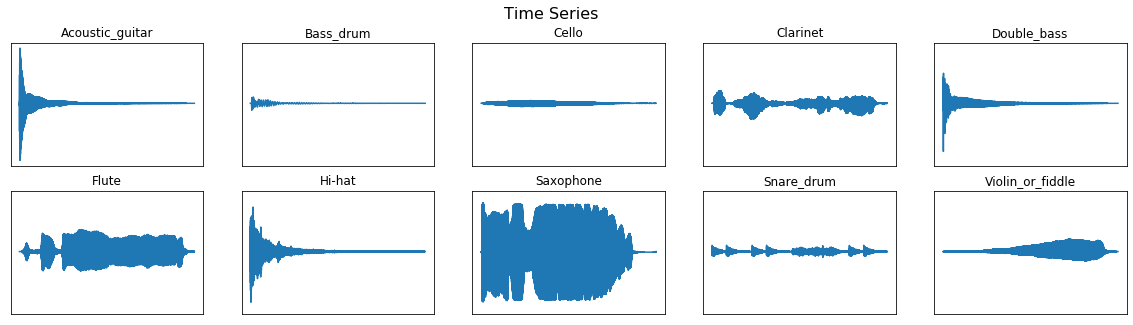

In [80]:
plot_signals(signals)
plt.show()

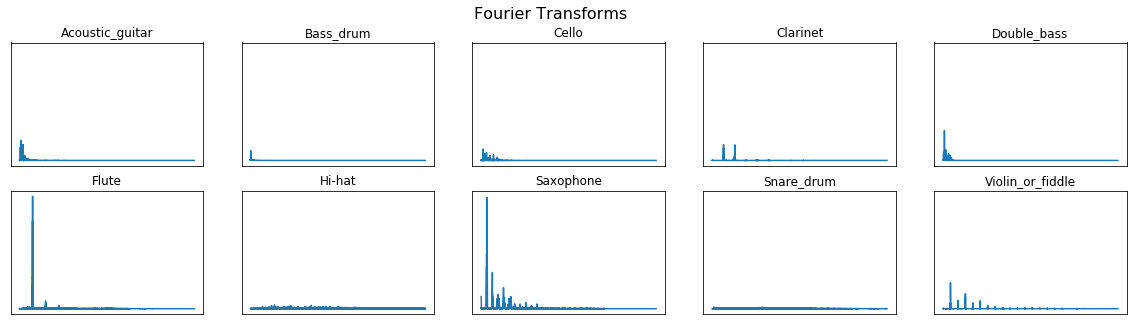

In [81]:
plot_fft(fft)
plt.show()

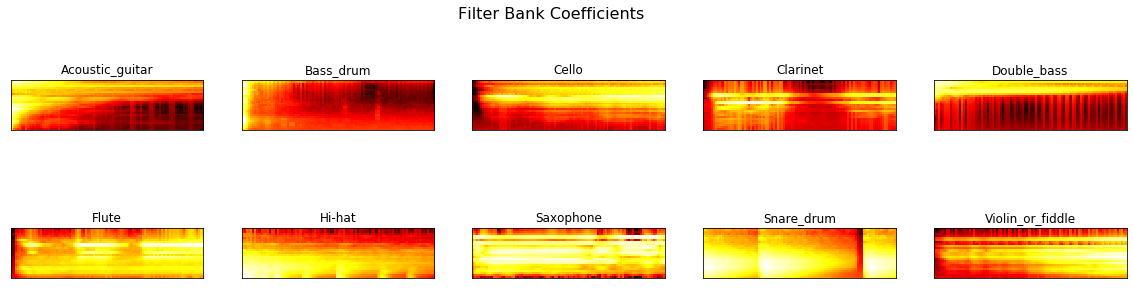

In [82]:
plot_fbank(fbank)
plt.show()

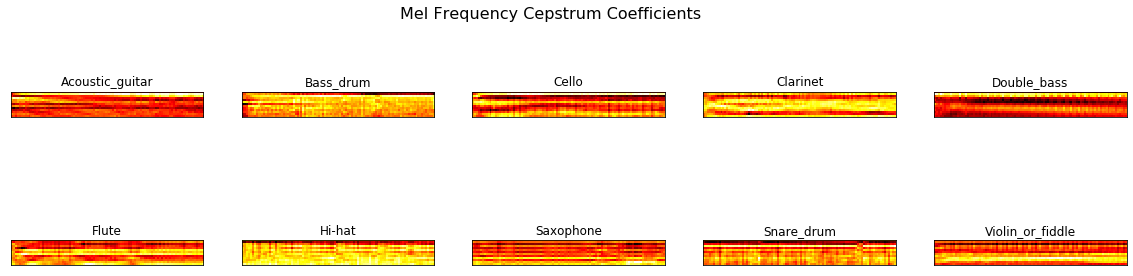

In [83]:
plot_mfccs(mfccs)
plt.show()

In [88]:
if len(os.listdir('cleanwav')) == 0:
    for f in tqdm(df.fname):
        signal, rate = librosa.load('/home/darpan/Documents/audio classification/wavfiles/'+f, sr = 16000)
        mask = envelope(signal, rate, 0.0005)
        wavfile.write(filename = '/home/darpan/Documents/audio classification/cleanwav/'+f, rate = rate, data =signal[mask])

100%|██████████| 300/300 [01:53<00:00,  2.65it/s]
